<a href="https://colab.research.google.com/github/benjamin-du/all_things_trees/blob/main/1.%20Understand_how_trees_work_visually_the_split_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")


     |████████████████████████████████| 61kB 6.0MB/s 


In [ ]:
from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from functools import partial

# TL; DR

<p style="font-family: Georgia">Trees form the basis of many modern machine-learning algorithms.  Yet many people don't really know how they work. This series of articles aims at helping you develop a strong intuition about what kind of decisions your algorithm will make and why. We'll also see along the way what you don't want to do when you use tree-based algorithms. 
To help you gain these intuitions, we'll learn how to code a tree, of course, but most importantly we will walk through a lot of visualizations and minimal-case scenarii.</p>

PLEASE NOTE: you'll see very simple plots of IRIS datasets and such in the first posts. If you are an advanced reader, please don't dismiss the entire series on this fact. The latter posts will build on these simple examples to analyze far more complex situations :)

# Understanding trees, visually

We start by loading the iris dataset. It contains data about flowers. We'd like to know if we can predict the "specie" of the flower given its characteristics:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
iris_df = sns.load_dataset("iris")

iris_df.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,species
27,5.2,3.5,1.5,0.2,setosa
133,6.3,2.8,5.1,1.5,virginica
135,7.7,3.0,6.1,2.3,virginica


If you don't know what a sepal is, I advise you look it up online, so that you can visualize what we are talking about at each step. 


First, let's plot some histograms. How many flowers have a petal_lenght < 2.5 ? What specie are they all coming from ?

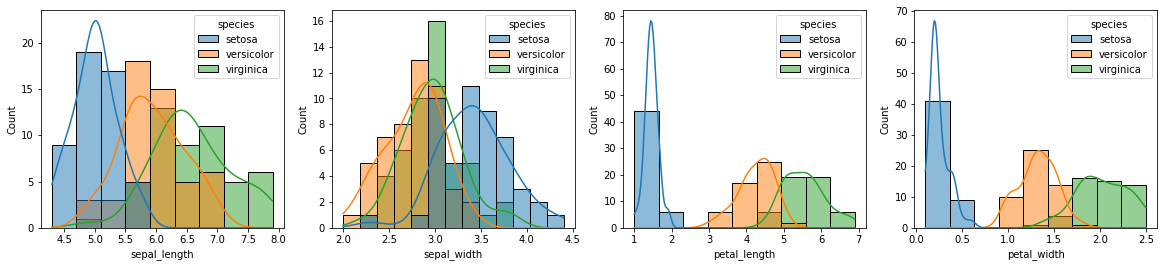

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, column in enumerate(iris_df.columns.tolist()[:-1]):
    sns.histplot(x=column, data=iris_df, hue="species", kde=True, ax=axes[i])

You got it. There is a characteristics (a "feature"), that will help us decide whether a particular flower is a setosa or not. It is the size of its petal (width or lenght will do). Of course, a decision tree is capable of figuring that out (note that I ask for a tree with a max_depth of one. So it finds the best split it can do on all the data and stops there:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


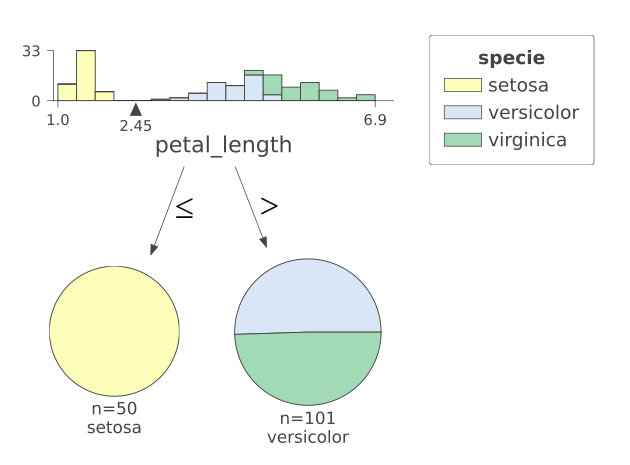

In [ ]:
X_train = iris_df.iloc[:, :4]
y_train = iris_df['species']

def make_classification_and_plot_tree(X_train, y_train, max_depth=1, min_samples_leaf=1):
    labels = y_train.unique().tolist()
    y_train = y_train.map({"setosa": 0, "versicolor":1, "virginica":2})
    clas = tree.DecisionTreeClassifier(max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf)  
    clas.fit(X_train.values, y_train)

    viz = dtreeviz(clas,
                   X_train,
                   y_train,
                   target_name='specie',
                   feature_names=X_train.columns.tolist(),
                   class_names=labels, 
                   histtype= 'barstacked',
                   scale=2.5)

    return viz

viz = make_classification_and_plot_tree(X_train, y_train)
viz

We are entering the mechanics of the tree now !
If you run the above cell multiple times, you will see that either petal_length or petal_width is chosen. That's because splitting on one or the other doesn't affect the result at all (Look at the histograms above to convince yourself of that)

But we could tweak our dataset to make the process a little bit more deterministic... If we wanted petal_length to be selected all the time as first split, we would need to find a way to make the split with petal_width less perfect.

To do that, we could create a row that contains a "versicolor" specie, and make it so that this flower has the petal_witdh of a "setosa"

In [ ]:
# Let's pick a versicolor: 
subset = iris_df[ iris_df['species'] == "versicolor"].copy()
print("Min petal_width for a versicolor:", subset['petal_width'].min())
# Let's find the mean value for petal_width for a setosa
setosas = iris_df[ iris_df['species'] == "setosa"].copy()
print("Max petal_width for a setosa:", setosas['petal_width'].mean() )
random_versicolor = subset.sample(1)
random_versicolor['petal_width'] = setosas['petal_width'].mean()  # affect a "setosa" kind of width
print("random_versicolor:  \n", random_versicolor)

Min petal_width for a versicolor: 1.0
Max petal_width for a setosa: 0.2459999999999999
random_versicolor:  
     sepal_length  sepal_width  petal_length  petal_width     species
79           5.7          2.6           3.5        0.246  versicolor


In [ ]:
iris_df = iris_df.append(random_versicolor)
iris_df.tail(3)

,sepal_length,sepal_width,petal_length,petal_width,species
148,6.2,3.4,5.4,2.300,virginica
149,5.9,3.0,5.1,1.800,virginica
79,5.7,2.6,3.5,0.246,versicolor


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


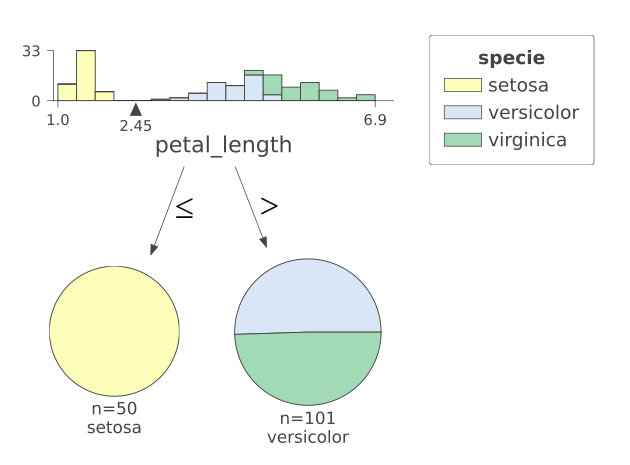

In [ ]:
X_train = iris_df.iloc[:, :4]
y_train = iris_df['species']

make_classification_and_plot_tree(X_train, y_train)

You can run the above cell how many times you would like, petal_width is not going to be selected as first split anymore. To gain even more intuition, let's remove the feature "petal_length" (now our best predictor) and plot again the graph:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


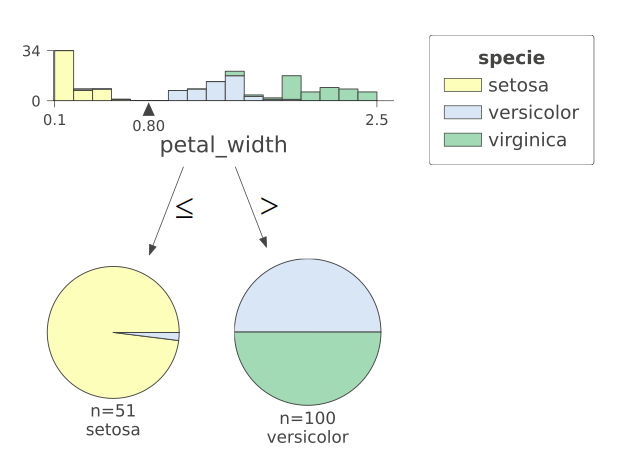

In [ ]:
X_train = iris_df[['sepal_length', 'sepal_width', 'petal_width']]
y_train = iris_df['species']

make_classification_and_plot_tree(X_train, y_train)

As you can see, now that is doesn't have access to the best predictor variable, the tree falls back on the second best. But this gives us a split that is not perfect ! 
What will happen then ? We can split the data ourselves and keep feeding it to a tree that has a max_depth of 1:

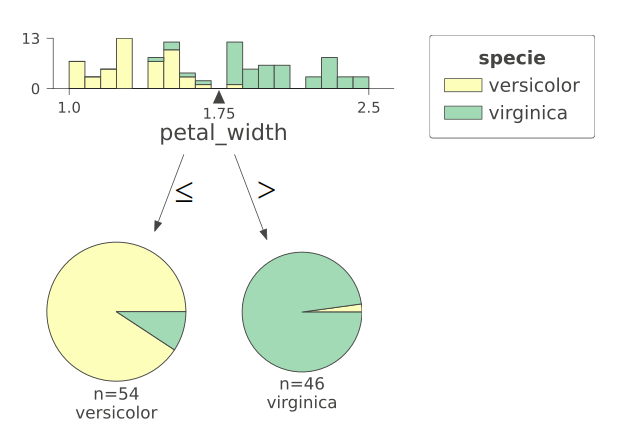

In [ ]:
right_split = iris_df[ iris_df['petal_width'] > 0.8].copy()
X_train = right_split[['sepal_length', 'sepal_width', 'petal_width']]
y_train = right_split['species']

make_classification_and_plot_tree(X_train, y_train)

Again, the best variable to separate versicolor and virginica in the petal_width. You can convince yourself ot that with the following histogram:

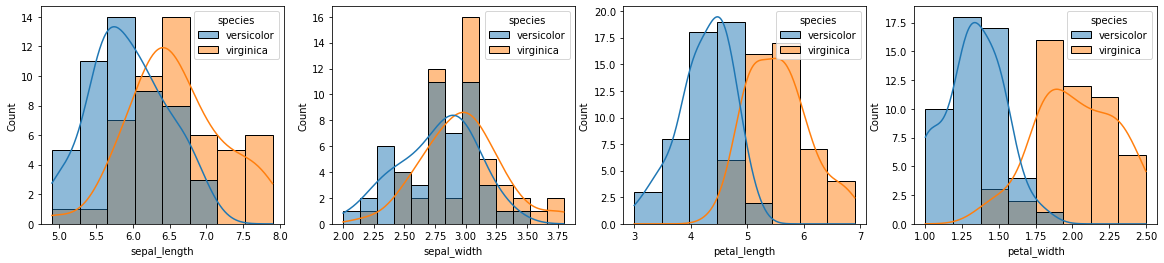

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, column in enumerate(right_split.columns.tolist()[:-1]):
    sns.histplot(x=column, data=right_split, hue="species", kde=True, ax=axes[i])

Note that the far-right histogram is showing you the same data than the histogram provided by dtreeviz. It's just another way to look at it.

Another way to intuitively understand the split: to make a split, a tree will choose the variable where there the overlap between the distributions of the target variable is the smallest !

# The tree keeps splitting 

Let's see what happens if we don't tell the tree to stop at a depth of 1:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


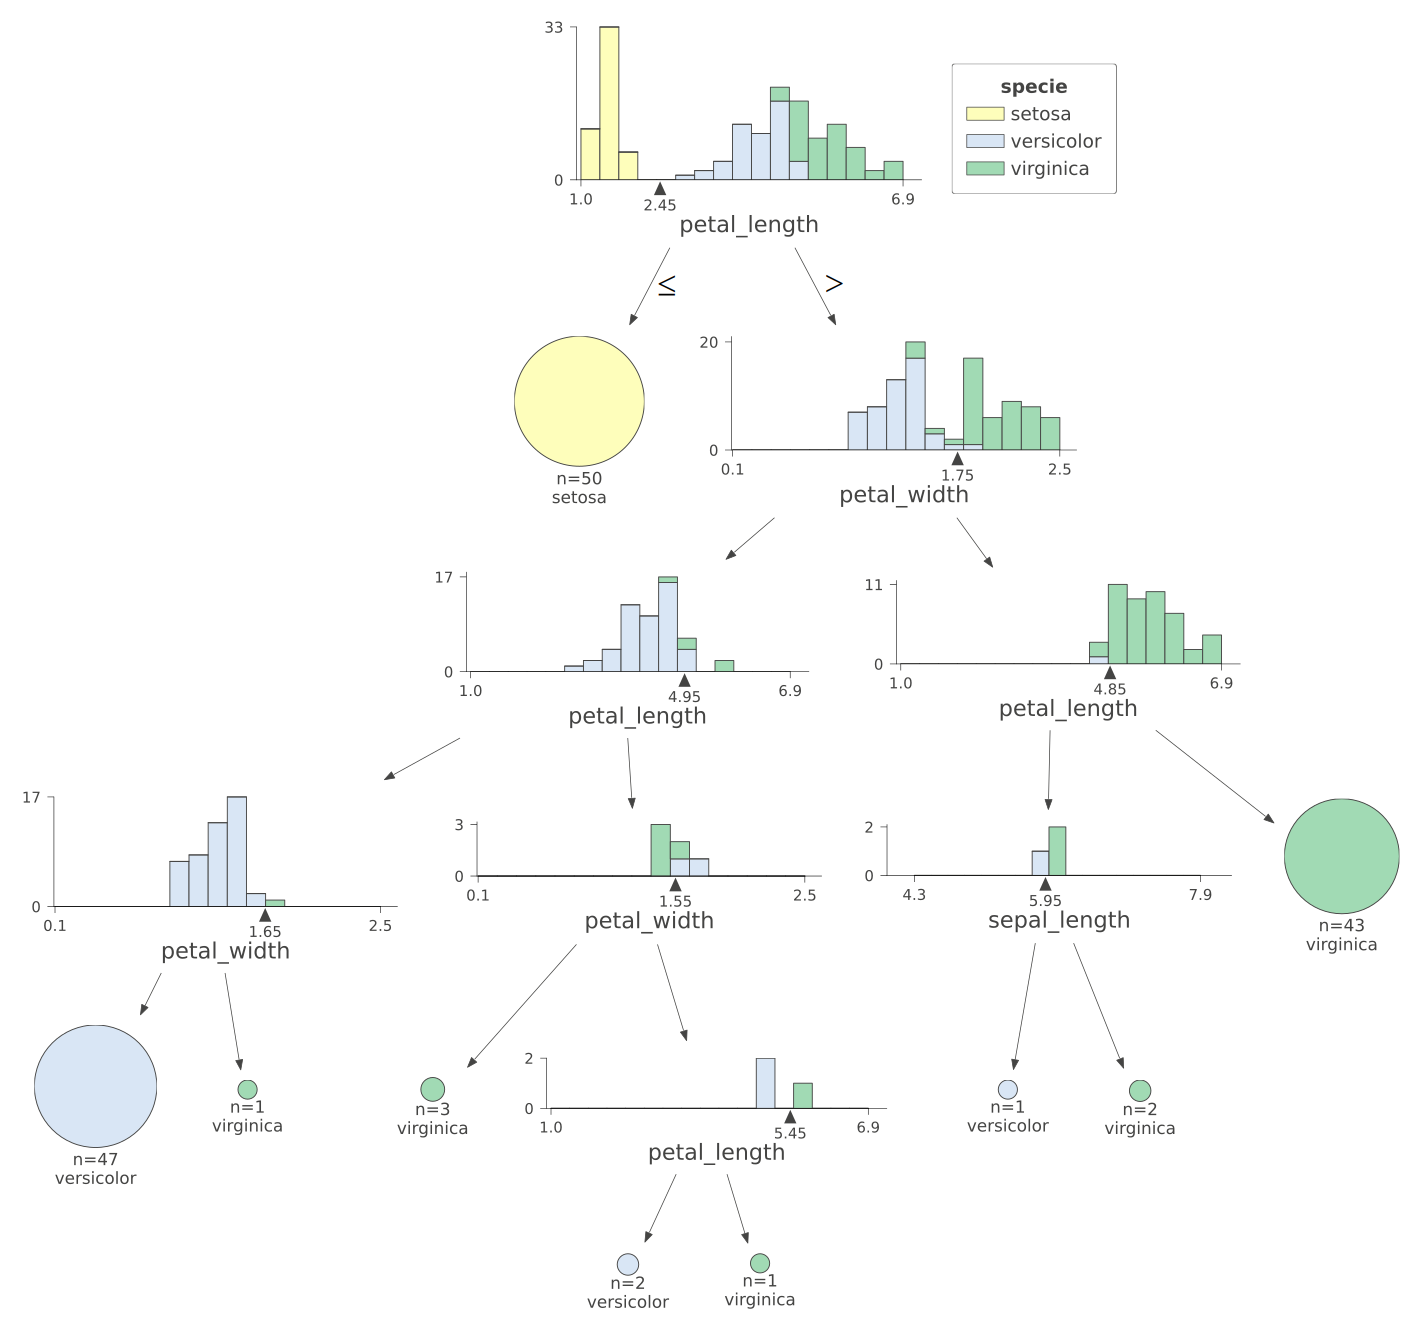

In [ ]:
X_train = iris_df.iloc[:150, :4]
y_train = iris_df['species'].iloc[:150]
make_classification_and_plot_tree(X_train, y_train, max_depth=None)

You recognized the first two splits on petal_length to isolate the setosas, then on petal_width because it's the variable where virginicas and versicolors are the most different... But then, plenty of stuff is still happening, and it's not clear whether all of this makes sense !

Let's focus on the right part of the chart. We still have our "right_split" variable where we removed the setosas. Let's remove from it all the data where the petal_width is < 1.75:

In [ ]:
scnd_rght_splt = right_split[right_split['petal_width'] > 1.75].copy()
scnd_rght_splt.shape

(46, 5)

We are left we 46 flowers to categorize. That's right: 43 for the big far-right bubble, and 3 in the bottom-right two bubbles. That's also the 46 we had when we made the split on the "right_split" dataset with a max_depth of one (see two charts above). So far, so good.

Let's inspect that data:

In [ ]:
scnd_rght_splt["species"].value_counts()

virginica     45
versicolor     1
Name: species, dtype: int64

In that split, we have only one versicolor... Yet if you look at the graph, we are going to have to make <b> two more splits </b> just to isolate this observation.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


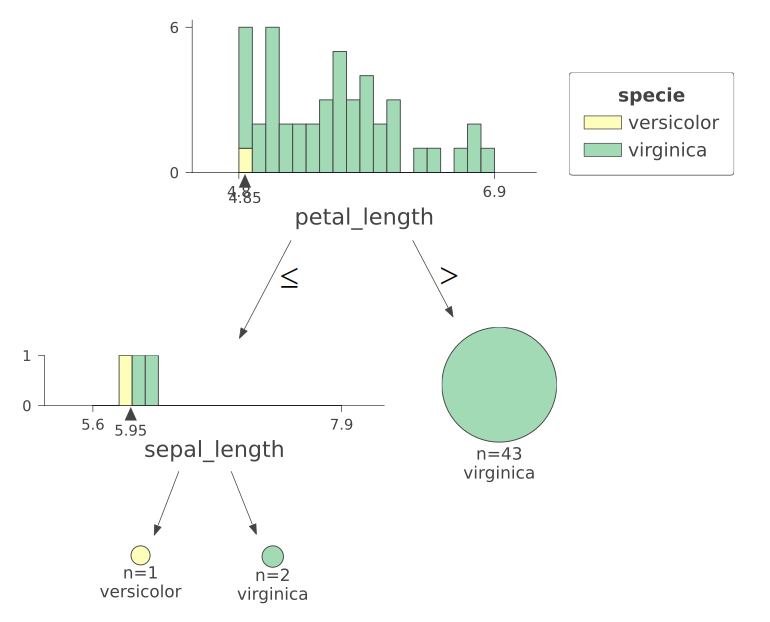

In [ ]:
X_train = scnd_rght_splt.iloc[:, :4]
y_train = scnd_rght_splt['species']
make_classification_and_plot_tree(X_train, y_train, max_depth=None)

Let's write, in plain english, how our model split the data to create a leaf for this particular instance:

- is the petal lenght > 2.45 ? Yes
- Then is the petal width > 1.75 ? Yes
- Then is the petal lenght > 4.85 ? No ?
- Then in that case, surely the sepal lenght is > to 5.95... 
- No ?! Then <b> it has to be a versicolor </b> ! 

That's a ridiculous claim. Especially since the two observations are so close: 

In [ ]:
scnd_rght_splt[ scnd_rght_splt['petal_length'] < 4.85]

,sepal_length,sepal_width,petal_length,petal_width,species
70,5.9,3.2,4.8,1.8,versicolor
126,6.2,2.8,4.8,1.8,virginica
138,6.0,3.0,4.8,1.8,virginica


Will you find out there in the world a versicolor of sepal_length > 5.9 ? You bet your ass. In fact, there are plenty in this dataset:

In [ ]:
iris_df[ iris_df['species'] == "versicolor"].sort_values("sepal_length").tail(3)

,sepal_length,sepal_width,petal_length,petal_width,species
76,6.8,2.8,4.8,1.4,versicolor
52,6.9,3.1,4.9,1.5,versicolor
50,7.0,3.2,4.7,1.4,versicolor


However, these examples have pretty small petal_widths... is it possible that if a versicolor has a big petal_width, then is has to have a smaller sepal_length ? It could be. That's when your expertise stops and you have to go talk with a domain expert.

Doing this to ensure each split makes sense, however, would be very time consuming. There are a few steps you can take to ensure your tree is not going to be too complex:

# max_depth
We've already seen max_depth. I used it mainly to keep the graphs as simple as possible, but in fact it may be the most important parameter of a decision-tree. Let's see what a tree looks like on _all_ the data, with a max_depth of 3:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


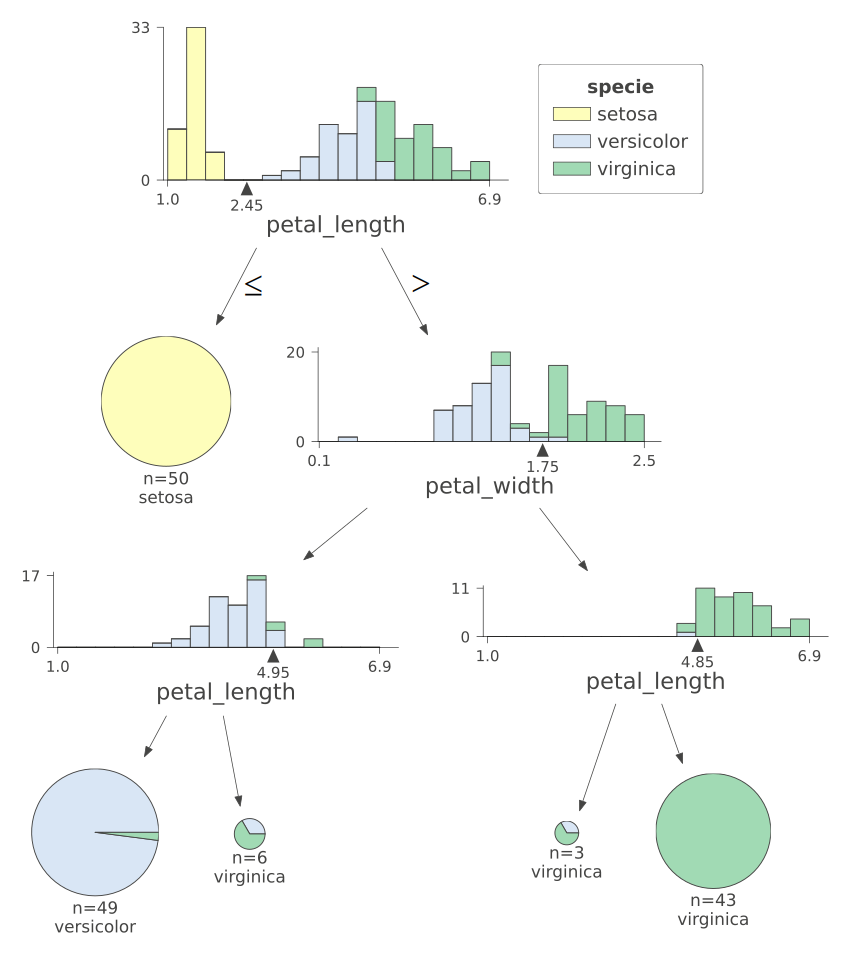

In [ ]:
X_train = iris_df.iloc[:, :4]
y_train = iris_df['species']

viz = make_classification_and_plot_tree(X_train, y_train, max_depth=3)
viz

# min_samples_leaf

The above tree looks perfectly fine. If you wanted a little bit more subtlety, you can use "min_samples_leaf". 

In plain english, min_samples_leaf means "please don't make a decision unless you have several examples to back it up". By default, this value is 1. That means that as long as you have one observation that fits a certain chain of decision, it's ok to create the split for it.

You could ask your model the following: 

You want me to believe that this:
<quote>
- is the petal lenght > 2.45 ? Yes
- Then is the petal width > 1.75 ? Yes
- Then is the petal lenght > 4.85 ? No ?
- Then in that case, surely the sepal lenght is > to 5.95... 
- No ?! Then <b> it has to be a versicolor </b> ! 
</quote>
... is a valid way of splitting the data ? Ok, then show me at least 6 observations that follow this pattern.

Of course, in our case, we only had one instance of that particular chain of decisions. So if we had asked our model for a min_sample_leaf of 6, it would not have dared to come up with such a ridiculous way of splitting the data just to make each leaf look "perfect"...

Let's see what happens with this parameter:


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


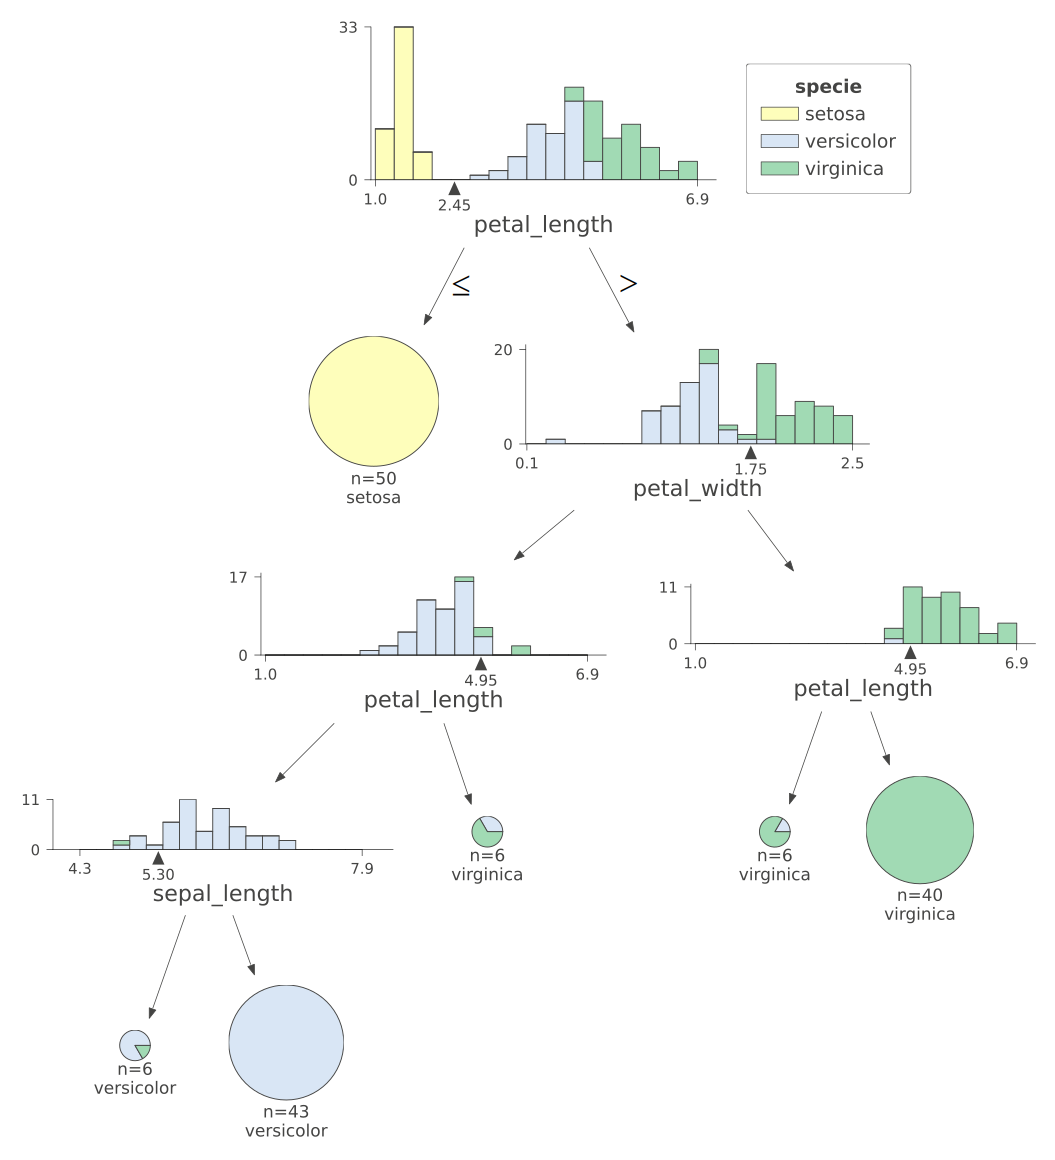

In [ ]:
viz = make_classification_and_plot_tree(X_train, y_train, max_depth=None, min_samples_leaf=6)
viz

Note that this tree, while more complex, doesn't change anything in the final decision. Everything on the right of the graph will still be classified as a virginica, while we also make a split on "sepal_length" on the left, only to have each leaf predict "versicolor".

# How do I pick these parameters ? 

Most of you know the answer: train-test split to ensure correct generalization. There are multiple flavors of it, from the simple sklearn train_test_split to the costly gridSearch CrossValidation.

However, avoiding overfitting in Machine Learning is a <a href="https://www.fast.ai/2017/11/13/validation-sets/">whole subject</a> in and off itself, and off the scope of this series. 

The goal of this post was to gain a thorough understanding of how a decision tree behaves. 
This will help us understand the pitfalls they have, and the way we can help them with feature engineering.

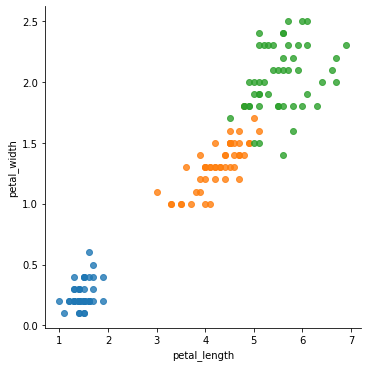

In [ ]:
sns.lmplot(x="petal_length", y="petal_width", data=iris, hue="species", fit_reg=False, legend=False)

In the end, petal width and petal lenght are enough to robustly classify those flowers.

In [ ]:
# what happens if I give an already trained classifier only part of the data to graphviz ?
# categorical variables (beer from 18+ to 99 in Northern France close to Belgium)
# ET DONC ? ou MAIS ! + ENJEU EMOTIONNEL: "you'll be able to show the stakeholders that it all makes sense"

In [ ]:
# What is the goal ? Understand the root of your decision tree
# Why is it important ? Face the interview, (or the coding game question) OR be cristal-clear when you explain your stuff to stakeholders
# What obstacles will you face ? Technical habits: present you MSE or ROC-AUC or confusion-matrix
# Un conflit, des obstacles, une résolution; And so; But; Don't tell, show! 

In [ ]:
# not popular truth: you can't and SHOULD NOT LEARN everything
# data scientist should be data engineers as well 
# T-shaped skills: enough data engineering, huge depth on two major data science algorithms
# most courses are done by people in the field since they were fifteen (or univ professors); they are not in your shoes, they don't know what you need to succeed
# 